In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import os

sys.path.append(os.path.dirname(os.getcwd())) 
from source.model_output import SEIRModelOutput, SEIRParams
from source.SEIR_network import SEIRNetworkModel

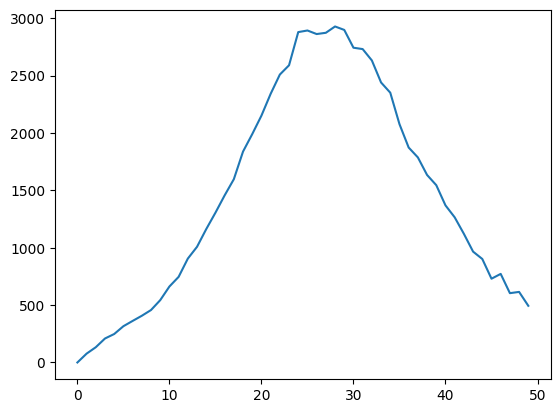

In [10]:
incidence = np.loadtxt('../data/incidence_synthetic_curve.csv')
plt.plot(incidence[:50])